In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# from utils import read_data, visualize_data
# from utils.read_data import *
# from utils.visualize_data import *

from singlecell.read import read_single_cell_sql
from singlecell.process import extract_single_cell_samples
from singlecell.visualize import visualize_n_SingleCell
from singlecell.preprocess.filter_out_edge_single_cells import edgeCellFilter
from singlecell.save.save_pandas_dfs import saveDF_to_CSV_GZ_no_timestamp
from singlecell.preprocess import handle_nans, extract_cpfeature_names,find_highly_correlated_features
# from sklearn.cluster import KMeans
import time

Metadata for all jump datasets can be downloaded from: https://github.com/jump-cellpainting/jump-perturbation-lists

In [2]:
jump_orf_meta_tsv="/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/metadata/JUMP-ORF/ORF_list.tsv"
annot=pd.read_csv(jump_orf_meta_tsv,sep='\t')
annot['batch_plate']=annot['Batch']+'-'+annot['Assay_Plate_Barcode']
batches=annot['Batch'].unique()
# feature_list=['Cytoplasm_AreaShape_Zernike_9_3',\
#  'Cells_RadialDistribution_RadialCV_Mito_1of4',\
#  'Cytoplasm_Granularity_3_RNA']
# feature_list=['Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16',\
# 'Nuclei_Texture_Contrast_mito_8_0',\
# 'Cells_Texture_SumEntropy_mito_8_45',\
# 'Nuclei_Texture_DifferenceVariance_mito_8_0']

feature_list=['Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16']

annot.head()

,Symbol,plate_map_name,Batch,Assay_Plate_Barcode,well_position,broad_sample,pert_type,control_type,batch_plate
0,A1BG,OAC18.OAB81.82.83.A,2021_08_09_Batch11,BR00126545,C15,ccsbBroad304_10667,trt,NaN,2021_08_09_Batch11-BR00126545
1,A1BG,OAC18.OAB81.82.83.A,2021_08_09_Batch11,BR00126547,C15,ccsbBroad304_10667,trt,NaN,2021_08_09_Batch11-BR00126547
2,A1BG,OAC18.OAB81.82.83.A,2021_08_09_Batch11,BR00126546,C15,ccsbBroad304_10667,trt,NaN,2021_08_09_Batch11-BR00126546
3,A1BG,OAC18.OAB81.82.83.A,2021_08_09_Batch11,BR00126548,C15,ccsbBroad304_10667,trt,NaN,2021_08_09_Batch11-BR00126548
4,A1BG,OAC18.OAB81.82.83.A,2021_08_09_Batch11,BR00126549,C15,ccsbBroad304_10667,trt,NaN,2021_08_09_Batch11-BR00126549


In [18]:
# annot[annot['pert_type']=='control']
annot[annot['control_type']=='negcon'].groupby(['Symbol']).size()

Symbol
BFP            973
HcRed          973
LUCIFERASE     973
LacZ           973
eGFP          2026
dtype: int64

In [19]:
annot['pert_type'].unique()

array(['trt', 'control', nan], dtype=object)

In [24]:
annot[annot['pert_type'].isnull()].groupby(['Assay_Plate_Barcode']).size()

Assay_Plate_Barcode
BR00117035    18
BR00117036    18
BR00117037    16
BR00117038    16
BR00117039    16
              ..
BR00126714    12
BR00126715    12
BR00126716    12
BR00126717    12
BR00126718    12
Length: 237, dtype: int64

In [3]:
# annot[annot['pert_type'].isnull()]

In [4]:
# ls /home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/per_site_aggregated_profiles/jump_orf/

### Read aggregated profiles

In [5]:
import pandas as pd
from sqlalchemy import create_engine
from functools import reduce
import gc

root_dir_data='/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/'

df_agg_all_batches_ls=[]
for b in batches:
    print(b)
    df_sag_ls=[]
    plates=annot.loc[annot['Batch']==b,'Assay_Plate_Barcode'].unique()
    for p in plates:
        fileName=root_dir_data+b+'/'+p+'/'+p+'.csv'
        sc_df=pd.read_csv(fileName)
#         per_site_aggregate=sc_df.groupby(['Metadata_Well','Metadata_Site']).mean()[feature_list+['Count_Cells']].reset_index()
        sc_df['Metadata_Batch']=b
        sc_df['Metadata_Plate']=p
        df_sag_ls.append(sc_df)
        del sc_df
        gc.collect()
    
    df_sag=pd.concat(df_sag_ls,axis=0)
    df_agg_all_batches_ls.append(df_sag)
#     vzvcz
    
df_agg_all_batches=pd.concat(df_agg_all_batches_ls,axis=0)

2021_08_09_Batch11


NameError: name 'vzvcz' is not defined

In [92]:
target_feature='Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16'
cp_features, cp_features_analysis_0 =  extract_cpfeature_names.extract_cpfeature_names(df_sag);
# sc_df, cp_features_analysis = handle_nans.handle_nans(sc_df,cp_features_analysis_0,fill_na_method='drop-rows');   
import pickle
with open('/home/ubuntu/workspace_mito/2016_08_01_RadialMitochondriaDistribution_donna/analysis2/control_patient_similar_features', 'rb') as fp:
    control_patient_similar_features = pickle.load(fp)

In [33]:
cp_features, cp_features_analysis_0 =  extract_cpfeature_names.extract_cpfeature_names(df_sag);
corr_math=df_sag[cp_features_analysis_0].corr()
corr_2target=corr_math[target_feature].abs().reset_index()
corr_2target=corr_2target[~corr_2target[target_feature].isnull()].reset_index(drop=True)
# corr_2target[corr_2target[target_feature]<0.1]
# corr_2target.sort_values(by=target_feature)
uncorr_feats=corr_2target[corr_2target[target_feature]<0.1]['index'].tolist()

,index,Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16
4527,Nuclei_Correlation_K_BFLow_AGP,0.000055
1599,Nuclei_Texture_InfoMeas1_BFLow_10_02_256,0.000068
859,Nuclei_Texture_InverseDifferenceMoment_Brightf...,0.000106
1922,Nuclei_Texture_Correlation_Brightfield_3_01_256,0.000127
282,Nuclei_Texture_SumAverage_ER_10_02_256,0.000208
...,...,...
3287,Cells_RadialDistribution_MeanFrac_mito_tubenes...,0.937731
1246,Cells_RadialDistribution_FracAtD_mito_tubeness...,0.942356
2561,Cells_RadialDistribution_FracAtD_mito_tubeness...,0.943667
2552,Cells_RadialDistribution_MeanFrac_mito_tubenes...,0.996608


In [88]:
# corr_2target
# low_phenstr_fs
uncorr_feats=corr_2target[corr_2target[target_feature]<0.1]['index'].tolist()
set(control_patient_similar_features) & set(uncorr_feats)
# len(control_patient_similar_features)

1092

In [32]:
corr_2target.sort_values(by=target_feature)['index'].tolist()[-10:]

['Cells_Correlation_Overlap_BFHigh_Mito',
 'Cells_Correlation_Overlap_BFLow_Mito',
 'Cells_Correlation_Overlap_Brightfield_Mito',
 'Cells_RadialDistribution_FracAtD_mito_tubeness_19of20',
 'Cells_RadialDistribution_MeanFrac_mito_tubeness_15of16',
 'Cells_RadialDistribution_MeanFrac_mito_tubeness_19of20',
 'Cells_RadialDistribution_FracAtD_mito_tubeness_16of16',
 'Cells_RadialDistribution_FracAtD_mito_tubeness_20of20',
 'Cells_RadialDistribution_MeanFrac_mito_tubeness_20of20',
 'Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16']

In [84]:
# corr_2target
# uncorr_feats
similar_fs_2remove=find_highly_correlated_features.find_correlation(df_sag[uncorr_feats], threshold=0.9, remove_negative=True)

### Create per site aggregate level of data for a few features

In [ ]:
import pandas as pd
from sqlalchemy import create_engine
from functools import reduce
import gc

if 1:
    sg=pd.read_csv("/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/per_site_aggregated_profiles/jump_orf/"+\
    batches[0]+"_site_agg_profiles2.csv.gz")
    feature_list2=sg.columns[sg.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist()
    
    
else:
    feature_list2=feature_list+uncorr_feats_condese
    
    
root_dir_data='/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/'

for b in batches[6:]:
    print(b)
    df_sag_ls=[]
    plates=annot.loc[annot['Batch']==b,'Assay_Plate_Barcode'].unique()
    for p in plates:
        fileName=root_dir_data+b+'/'+p+'/'+p+'.sqlite'
        
        sc_df=read_single_cell_sql.readSingleCellData_sqlalch_features_subset(fileName,feature_list2)
        per_site_aggregate=sc_df.groupby(['Metadata_Well','Metadata_Site']).mean()[feature_list2+['Count_Cells']].reset_index()
        per_site_aggregate['Metadata_Batch']=b
        per_site_aggregate['Metadata_Plate']=p
        df_sag_ls.append(per_site_aggregate)
        del sc_df
        gc.collect()
    
    df_sag=pd.concat(df_sag_ls,axis=0)
    fileNameToSave="/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/per_site_aggregated_profiles/jump_orf/"+\
    b+"_site_agg_profiles2"
    saveDF_to_CSV_GZ_no_timestamp(df_sag,fileNameToSave)

2021_06_21_Batch7
time elapsed: 14.932906377315522  mins
time elapsed: 14.883104904492695  mins
time elapsed: 14.178551844755809  mins
time elapsed: 14.003269577026368  mins
time elapsed: 15.551953415075937  mins
time elapsed: 16.2419504404068  mins
time elapsed: 16.790350433190664  mins
time elapsed: 14.989886196454366  mins
time elapsed: 15.629440677165984  mins
time elapsed: 15.86985367933909  mins
time elapsed: 15.20950978199641  mins
time elapsed: 16.00100847482681  mins
time elapsed: 14.97692266702652  mins
time elapsed: 16.7474213719368  mins
time elapsed: 15.312049905459086  mins
time elapsed: 15.866656812032064  mins
time elapsed: 16.094700407981872  mins
time elapsed: 15.473737545808156  mins
time elapsed: 14.706438489754994  mins
time elapsed: 14.919009510676066  mins


/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/save/save_pandas_dfs.py:40: RuntimeWarning: compression has no effect when passing a non-binary object as input.
  df.to_csv(fd,index=False,compression='gzip')


2021_05_10_Batch3
time elapsed: 18.01094565788905  mins
time elapsed: 17.385928400357564  mins
time elapsed: 17.619332973162333  mins
time elapsed: 18.03251296679179  mins
time elapsed: 18.10636297861735  mins
time elapsed: 17.003805394967397  mins
time elapsed: 17.372460548082987  mins
time elapsed: 16.896117266019186  mins
time elapsed: 16.256966861089072  mins
time elapsed: 16.21310909986496  mins
time elapsed: 17.54618866443634  mins
time elapsed: 18.350974142551422  mins
time elapsed: 17.402734299500782  mins
time elapsed: 17.497377177079517  mins
time elapsed: 16.84134596188863  mins
time elapsed: 15.791864999135335  mins
time elapsed: 17.055461808045706  mins
time elapsed: 17.42158099412918  mins
time elapsed: 17.321309038003285  mins
time elapsed: 16.83996974627177  mins


/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/save/save_pandas_dfs.py:40: RuntimeWarning: compression has no effect when passing a non-binary object as input.
  df.to_csv(fd,index=False,compression='gzip')


2021_06_14_Batch6
time elapsed: 13.976339157422384  mins
time elapsed: 14.084625820318857  mins
time elapsed: 14.942203760147095  mins
time elapsed: 14.211505607763927  mins
time elapsed: 15.305803136030834  mins
time elapsed: 15.211620752016703  mins
time elapsed: 14.819344492753347  mins
time elapsed: 14.833082501093546  mins
time elapsed: 15.32266043027242  mins
time elapsed: 13.906518828868865  mins
time elapsed: 13.771759021282197  mins
time elapsed: 14.391654284795125  mins
time elapsed: 15.222191588083904  mins
time elapsed: 16.44795973698298  mins


/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/save/save_pandas_dfs.py:40: RuntimeWarning: compression has no effect when passing a non-binary object as input.
  df.to_csv(fd,index=False,compression='gzip')


2021_08_23_Batch12
time elapsed: 16.54422611395518  mins
time elapsed: 16.647533905506133  mins
time elapsed: 17.937228616078695  mins
time elapsed: 16.372386264801026  mins
time elapsed: 16.39537465174993  mins
time elapsed: 17.317646022637685  mins
time elapsed: 17.58523121277491  mins
time elapsed: 16.048265123367308  mins
time elapsed: 17.325342261791228  mins
time elapsed: 17.76936718225479  mins
time elapsed: 16.896092955271403  mins


/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/save/save_pandas_dfs.py:40: RuntimeWarning: compression has no effect when passing a non-binary object as input.
  df.to_csv(fd,index=False,compression='gzip')


2021_08_30_Batch13
time elapsed: 23.167779537041984  mins
time elapsed: 22.22013478676478  mins
time elapsed: 21.577758649984997  mins
time elapsed: 23.765461734930675  mins
time elapsed: 23.327778681119284  mins
time elapsed: 21.236642221609753  mins
time elapsed: 18.707892537117004  mins
time elapsed: 18.249067572752633  mins
time elapsed: 19.62855467796326  mins
time elapsed: 20.146738449732464  mins
time elapsed: 19.80569397608439  mins


/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/save/save_pandas_dfs.py:40: RuntimeWarning: compression has no effect when passing a non-binary object as input.
  df.to_csv(fd,index=False,compression='gzip')


2021_05_17_Batch4
time elapsed: 16.932918564478555  mins
time elapsed: 16.592473224798837  mins
time elapsed: 16.32274607817332  mins
time elapsed: 14.953849176565805  mins
time elapsed: 17.218959883848825  mins
time elapsed: 17.281839509805042  mins
time elapsed: 16.041461392243704  mins
time elapsed: 16.19623116652171  mins
time elapsed: 16.404680867989857  mins
time elapsed: 17.63846744696299  mins
time elapsed: 16.237673795223238  mins
time elapsed: 16.46471667687098  mins
time elapsed: 16.479207368691764  mins
time elapsed: 17.510788134733836  mins
time elapsed: 16.424393697579703  mins
time elapsed: 16.16789928674698  mins
time elapsed: 17.131679944197337  mins
time elapsed: 15.973966455459594  mins
time elapsed: 15.898419630527496  mins
time elapsed: 16.71217664082845  mins


/home/ubuntu/workspace_SingleCell/SingleCell_Morphological_Analysis/singlecell/save/save_pandas_dfs.py:40: RuntimeWarning: compression has no effect when passing a non-binary object as input.
  df.to_csv(fd,index=False,compression='gzip')


2021_08_02_Batch10
time elapsed: 14.087655174732209  mins
time elapsed: 15.135654671986897  mins
time elapsed: 18.337819584210713  mins
time elapsed: 15.357511711120605  mins
time elapsed: 14.496170314153035  mins
time elapsed: 17.55728397369385  mins
time elapsed: 19.682865758736927  mins
time elapsed: 15.987926208972931  mins
time elapsed: 17.512877313296  mins


In [15]:
"/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/per_site_aggregated_profiles/jump_orf/"+\
    batches[0]+"_site_agg_profiles2.csv.gz"

'/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/per_site_aggregated_profiles/jump_orf/2021_08_09_Batch11_site_agg_profiles2.csv.gz'

In [5]:
2021_08_09_Batch11
time elapsed: 11.370365146795908  mins
time elapsed: 11.272136795520783  mins
time elapsed: 11.654087197780608  mins
time elapsed: 10.991566630204519  mins
time elapsed: 11.083784727255503  mins

13

### Load per_site aggregated data and screen for target feature to create a ranked list

In [18]:
import pandas as pd
from sklearn import linear_model
from sqlalchemy import create_engine
from functools import reduce
import gc

per_site_profiles_path="/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/per_site_aggregated_profiles/"
# feature_list=['Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16',\
#              'Nuclei_Texture_DifferenceVariance_Mito_10_00_256',\
#              'Nuclei_Texture_Contrast_Mito_10_00_256']
feature_list=['Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16']


if 1:
    sg=pd.read_csv("/home/ubuntu/bucket/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/per_site_aggregated_profiles/jump_orf/"+\
    batches[0]+"_site_agg_profiles2.csv.gz")
    uncorr_feats_condese=sg.columns[sg.columns.str.contains("Cells_|Cytoplasm_|Nuclei_")].tolist()[1:]


cols2remove_lowVars=[]
per_site_df_ls=[]
for b in batches:
    fileNameToSave=per_site_profiles_path+"/jump_orf/"+\
    b+"_site_agg_profiles2"

    per_site_df_b=pd.read_csv(fileNameToSave+'.csv.gz')


    def control_feature_y_for_variable_x(df,y_col_name,x_col_name):

        ransac = linear_model.RANSACRegressor(min_samples=0.9)

        x2=df[x_col_name].values[:,np.newaxis]
        y2=df[y_col_name].values[:,np.newaxis]

        lm=ransac.fit(x2, y2)  ### means that we have controled for aggregated per site features
        df[y_col_name+'_ccOut']=y2 - lm.predict(x2)

        return df

    per_site_df_b=control_feature_y_for_variable_x(per_site_df_b,feature_list[0],'Count_Cells')
    
    thrsh_std=0.001
    cols2remove_lowVars+=per_site_df_b[uncorr_feats_condese].std()[per_site_df_b[uncorr_feats_condese].std() < thrsh_std].\
    index.tolist()
    
    per_site_df_ls.append(per_site_df_b)

per_site_df=pd.concat(per_site_df_ls,axis=0,ignore_index=True)
per_site_df['batch_plate']=per_site_df['Metadata_Batch']+'-'+per_site_df['Metadata_Plate']


per_site_df=pd.merge(per_site_df, annot, how='left',left_on=['batch_plate','Metadata_Well'],\
                     right_on=['batch_plate','well_position'])

per_site_df=per_site_df[~per_site_df['pert_type'].isnull()].reset_index(drop=True)

uncorr_feats_condese = per_site_df.columns[per_site_df.columns.str.contains("Cells_|Nuclei_|Cytoplasm_")].tolist()[1:]
uncorr_feats_condese = list(set(uncorr_feats_condese) - set(cols2remove_lowVars))

In [7]:
# per_site_df_b[['pert_type','control_type']]
# per_site_df_b.columns

In [28]:
# per_site_df.columns[per_site_df.columns.str.contains("Cells_|Nuclei_|Cytoplasm_")].tolist()
len(set(cols2remove_lowVars))

108

In [25]:
cols2remove_lowVars

[['Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_4of20',
  'Nuclei_AreaShape_Zernike_6_2',
  'Nuclei_AreaShape_Zernike_8_2',
  'Cytoplasm_Correlation_K_BFLow_Brightfield',
  'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_11of20',
  'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_8of16',
  'Cytoplasm_Correlation_Overlap_BFLow_Brightfield',
  'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_5of16',
  'Cytoplasm_Correlation_Manders_ER_Brightfield',
  'Cells_AreaShape_Zernike_9_1',
  'Nuclei_AreaShape_Zernike_8_4',
  'Nuclei_Intensity_StdIntensityEdge_Brightfield',
  'Nuclei_Children_Cytoplasm_Count',
  'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_2of16',
  'Cytoplasm_RadialDistribution_RadialCV_mito_tubeness_5of20',
  'Cells_Correlation_K_BFHigh_BFLow',
  'Cells_RadialDistribution_FracAtD_mito_tubeness_1of20',
  'Cytoplasm_RadialDistribution_FracAtD_mito_tubeness_9of16',
  'Cells_RadialDistribution_MeanFrac_BFHigh_3of4',
  'Cytoplasm_RadialDistribution_RadialCV_mi

In [19]:
# annot.columns
# per_site_df

In [30]:
feature_list

['Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16',
 'Nuclei_Texture_DifferenceVariance_Mito_10_00_256',
 'Nuclei_Texture_Contrast_Mito_10_00_256']

In [23]:
##############################################

from scipy.stats import ttest_ind
results=annot[['Symbol','broad_sample', 'pert_type', 'control_type']].drop_duplicates().reset_index(drop=True)

feature_list2=list(set(feature_list+uncorr_feats_condese))

list_of_cols_2add=['p_'+f for f in feature_list2]+['t_'+f for f in feature_list2]+['Count_Cells_avg']
results=results.reindex(columns=results.columns.tolist() + list_of_cols_2add)

perts=per_site_df[per_site_df['pert_type']=='trt']['broad_sample'].unique()

for peri, pert in enumerate(perts):
    print(peri)
    per_site_df_pert=per_site_df[per_site_df['broad_sample']==pert].reset_index(drop=True)
    plates_pert=per_site_df_pert['batch_plate'].unique()
    
    
    pert_cell_count_perSite_all_plates=[]
    pert_pvals_all_plates=np.full((len(plates_pert),len(feature_list2)),np.nan)
    pert_tvals_all_plates=np.full((len(plates_pert),len(feature_list2)),np.nan)    

    for pi,plate in enumerate(plates_pert):
        per_site_df_pert_plate=per_site_df_pert[per_site_df_pert['batch_plate']==plate].reset_index(drop=True)
        pert_cell_count_perSite_all_plates.append(per_site_df_pert_plate['Count_Cells'].mean())

#         control_df=per_site_df[(per_site_df['pert_type']=='control') & \
        control_df=per_site_df[(per_site_df['Symbol']=='LacZ') & \
                    (per_site_df['batch_plate']==plate)].reset_index(drop=True)
        
        for ti,target_feat in enumerate(feature_list2):
            test_res=ttest_ind(per_site_df_pert_plate[target_feat], control_df[target_feat], equal_var=False)
#             print(test_res)
            pert_pvals_all_plates[pi,ti]=test_res.pvalue
            pert_tvals_all_plates[pi,ti]=test_res.statistic
    
    results.loc[results['broad_sample']==pert,'Count_Cells_avg']=np.mean(pert_cell_count_perSite_all_plates)        
    
    results.loc[results['broad_sample']==pert,['p_'+f for f in feature_list2]]=\
    np.nanmean(pert_pvals_all_plates,axis=0)
    results.loc[results['broad_sample']==pert,['t_'+f for f in feature_list2]]=\
    np.nanmean(pert_tvals_all_plates,axis=0)
    
results.sort_values(by=['t_'+feature_list[0]],ascending=False).to_csv(per_site_profiles_path+"/jump_orf/phenotype_strength_"+\
                                                     feature_list[0]+"_2.csv",index=False)

6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7823
7824


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7825


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7826


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7827


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7828


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7829


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7830


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7831


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7832


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7833
7834


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7835


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7836


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7837


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7838


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7839


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7840


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7841


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7842


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7843


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7844
7845


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7846
7847


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7848


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7849


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7850


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7851


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7852


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7853
7854


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7855


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7856


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7857


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7858


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7859


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7860


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7861


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7862


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7863


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7864


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7865


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7866


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7867


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7868


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7869
7870


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7871
7872


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7873


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7874


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7875


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7876


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7877


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7878
7879


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7880


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7881


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7882


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7883


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7884


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7885


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7886


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7887


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7888


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7889
7890


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7891
7892


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7893


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7894


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7895


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7896


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7897


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7898


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7899


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7900
7901


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7902


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7903


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7904


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7905
7906


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7907


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7908


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7909


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7910


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7911


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7912


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7913
7914


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7915


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7916


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7917


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7918


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7919


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7920


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7921


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7922


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7923


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7924


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7925


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7926


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7927


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7928


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7929
7930


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7931


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7932


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7933
7934


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7935


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7936


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7937
7938


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7939


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7940


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7941


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7942


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7943
7944


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7945


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7946


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7947


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7948


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7949


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7950


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7951


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7952


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7953


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7954


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7955


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7956


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7957


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7958
7959


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7960


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7961


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7962


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7963


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7964


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7965


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7966
7967
7968
7969


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7970


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7971


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7972


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7973


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7974


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7975


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7976


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7977


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7978


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7979


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7980


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7981


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7982


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7983


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7984


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7985


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7986


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7987


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7988


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7989


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7990


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7991
7992


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7993


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7994


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7995


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7996


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7997


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


7998
7999


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8000


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8001


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8002


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8003


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8004


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8005


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8006


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8007


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8008


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8009


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8010


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8011


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8012


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8013


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8014


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8015


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8016


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8017


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8018


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8019


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8020


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8021


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8022
8023


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8024


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8025
8026


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8027


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8028


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8029


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8030


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8031


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8032


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8033


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8034


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8035


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8036


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8037


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8038


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8039


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8040
8041


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8042


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8043
8044


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8045
8046


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8047


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8048


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8049


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8050
8051


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8052


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8053


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8054


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8055


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8056


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8057


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8058


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8059


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8060


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8061


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8062


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8063
8064


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8065


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8066


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8067
8068


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8069


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8070


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8071


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8072


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8073


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8074
8075


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8076


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8077


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8078


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8079


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8080


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8081


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8082


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8083


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8084


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8085


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8086
8087


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8088
8089


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8090


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8091


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8092


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8093


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8094


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8095


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8096


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8097


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8098


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8099


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8100
8101


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8102


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8103
8104


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8105


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8106


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8107
8108


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8109


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8110


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8111


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8112


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8113


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8114


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8115


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8116


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8117


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8118


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8119


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8120


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8121


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8122


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8123
8124


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8125
8126


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8127


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8128


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8129


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8130


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8131
8132


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8133
8134


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8135
8136


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8137


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8138


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8139
8140
8141


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8142


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8143


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8144


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8145


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8146


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8147


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8148
8149


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8150


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8151


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8152


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8153


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8154


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8155


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8156


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8157


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8158


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8159
8160


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8161


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8162


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8163


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8164


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8165


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8166


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8167


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8168


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8169


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8170


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8171


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8172


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8173


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8174


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8175


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8176


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8177


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8178


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8179


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8180


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8181
8182


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8183


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8184


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8185


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8186


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8187


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8188


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8189
8190


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8191


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8192
8193
8194


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8195


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8196


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8197


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8198


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8199
8200


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8201


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8202


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8203


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8204


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8205


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8206


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8207


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8208


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8209


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8210


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8211


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8212


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8213


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8214


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8215


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8216


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8217


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8218


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8219


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8220


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8221


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8222


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8223


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8224


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8225
8226
8227


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8228
8229


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8230


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8231


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8232


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8233
8234


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8235


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8236


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8237


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8238


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8239


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8240
8241


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8242


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8243


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8244
8245


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8246


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8247


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8248


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8249
8250


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8251


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8252


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8253


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8254


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8255


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8256


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8257


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8258


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8259


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8260


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8261


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8262


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8263


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8264
8265


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8266


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8267


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8268


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8269


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8270


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8271


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8272


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8273


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8274


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8275


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8276


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8277


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8278


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8279


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8280


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8281


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8282


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8283


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8284


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8285


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8286


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8287


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8288


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8289


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8290


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8291


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8292


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8293
8294


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8295


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8296


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8297


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8298


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8299


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8300


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8301


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8302


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8303


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8304


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8305


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8306


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8307


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8308


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8309


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8310


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8311


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8312


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8313


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8314


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8315


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8316


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8317


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8318


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8319
8320


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8321


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8322


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8323


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8324


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8325


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8326


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8327


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8328


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8329


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8330


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8331


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8332


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8333


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8334


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8335


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8336


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8337


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8338


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8339


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8340


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8341


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8342


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8343


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8344


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8345


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8346


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8347


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8348
8349


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8350


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8351


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8352


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8353


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8354
8355


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8356


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8357


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8358


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8359


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8360


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8361


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8362


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8363


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8364


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8365


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8366


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8367


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8368
8369


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8370


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8371


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8372


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8373


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8374


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8375


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8376


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8377


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8378
8379


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8380


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8381


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8382


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8383


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8384


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8385


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8386


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8387


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8388


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8389


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8390


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8391


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8392


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8393


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8394


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8395


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8396


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8397


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8398


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8399


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8400


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8401


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8402


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8403


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8404


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8405


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8406


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8407


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8408


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8409


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8410


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8411


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8412


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8413


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8414


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8415


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8416


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8417


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8418


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8419


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8420


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8421


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8422


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8423
8424


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8425


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8426
8427


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8428


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8429


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8430


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8431


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8432


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8433


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8434


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8435


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8436


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8437


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8438


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8439


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8440


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8441


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8442


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8443


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8444


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8445


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8446


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8447


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8448


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8449


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8450
8451


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8452


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8453


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8454


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8455


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8456


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8457


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8458


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8459


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8460


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8461


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8462


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8463


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8464


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8465


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8466


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8467


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8468


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8469
8470


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8471


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8472


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8473


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8474


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8475


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8476


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8477


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8478


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8479


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8480


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8481


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8482


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8483


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8484


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8485


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8486


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8487


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8488
8489


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8490


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8491


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8492


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8493


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8494


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8495


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8496


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8497
8498


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8499


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8500


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8501


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8502


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8503


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8504


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8505


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8506


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8507


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8508
8509


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8510


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8511


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8512


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8513


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8514


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8515


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8516


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8517


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8518


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8519


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8520


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8521


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8522


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8523


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8524


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8525


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8526


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8527


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8528


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8529


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8530


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8531


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8532
8533


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8534


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8535


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8536


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8537


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8538


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8539


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8540


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8541
8542


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8543


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8544


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8545


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8546


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8547


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8548


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8549
8550


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8551


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8552


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8553


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8554


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8555


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8556


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8557


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8558


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8559


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8560


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8561


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8562


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8563


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8564


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8565


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8566


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8567


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8568


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8569


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8570


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8571


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8572


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8573


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8574


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8575


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8576
8577


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8578


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8579


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8580


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8581


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8582


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8583


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8584


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8585


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8586


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8587


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8588


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8589


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8590


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8591


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8592


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8593


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8594


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8595


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8596


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8597


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8598


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8599
8600


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8601
8602


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8603
8604


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8605


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8606


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8607


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8608


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8609
8610


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8611


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8612


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8613


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8614


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8615


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8616
8617


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8618


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8619


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8620


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8621


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8622


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8623


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8624


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8625


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8626


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8627
8628


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8629


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8630


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8631


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8632


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8633


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8634


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8635


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8636
8637


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8638


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8639


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8640


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8641


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8642


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8643


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8644


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8645
8646


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8647
8648


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8649


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8650


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8651


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8652


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8653


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8654


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8655


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8656


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8657


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8658


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8659


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8660


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8661


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8662


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8663


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8664
8665


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8666


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8667


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8668


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8669


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8670


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8671


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8672


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8673


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8674


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8675


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8676


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8677


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8678


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8679


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8680
8681


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8682


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8683


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8684


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8685


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8686


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8687


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8688


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8689


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8690


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8691


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8692


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8693


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8694


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8695


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8696


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8697


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8698


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8699


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8700


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8701


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8702


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8703


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8704


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8705


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8706


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8707


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8708


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8709


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8710


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8711


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8712


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8713


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8714


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8715
8716


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8717


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8718


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8719
8720
8721


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8722


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8723


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8724


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8725


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8726


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8727


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8728
8729


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8730


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8731


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8732


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8733


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8734
8735


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8736


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8737


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8738


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8739


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8740


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8741


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8742


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8743


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8744


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8745


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8746


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8747


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8748


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8749
8750


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8751


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8752


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8753


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8754


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8755


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8756
8757


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8758


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8759


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8760


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8761


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8762
8763


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8764


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8765


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8766


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8767


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8768


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8769
8770


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8771


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8772


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8773


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8774


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8775
8776


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8777
8778


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8779


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8780


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8781


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8782


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8783


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8784


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8785


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8786


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8787


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8788
8789


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8790


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8791


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8792
8793
8794


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8795


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8796


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8797


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8798


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8799


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8800


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8801


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8802


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8803


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8804
8805


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8806


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8807


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8808


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8809


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8810


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8811


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8812
8813


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8814


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8815


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8816


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8817


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8818


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8819


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8820


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8821


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8822


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8823
8824


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8825


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8826


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8827


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8828


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8829
8830


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8831


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8832


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8833


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8834


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8835


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8836


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8837


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8838


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8839


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8840


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8841


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8842


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8843


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8844
8845


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8846


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8847


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8848


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8849


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8850


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8851


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8852


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8853


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8854


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8855


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8856
8857
8858


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8859


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8860


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8861


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8862


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8863


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8864


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8865


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8866


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8867


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8868


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8869


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8870


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8871


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8872


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8873
8874


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8875


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8876


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8877


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8878


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8879


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8880


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8881


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8882


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8883


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8884


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8885


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8886


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8887


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8888


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8889


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8890


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8891


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8892


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8893


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8894


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8895


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8896


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8897


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8898


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8899


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8900


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8901
8902


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8903


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8904
8905


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8906


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8907


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8908


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8909


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8910


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8911


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8912


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8913


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8914


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8915


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8916


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8917


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8918


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8919


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8920


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8921


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8922


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8923


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8924


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8925


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8926
8927


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8928


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8929
8930


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8931


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8932


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8933
8934


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8935


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8936


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8937


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8938


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8939


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8940


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8941


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8942


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8943


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8944


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8945


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8946


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8947


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8948


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8949


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8950


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8951


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8952
8953


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8954


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8955


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8956


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8957


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8958


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8959


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8960


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8961


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8962


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8963


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8964


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8965


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8966
8967
8968


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8969


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8970


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8971
8972


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8973


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8974


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8975


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8976


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8977


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8978


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8979


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8980


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8981
8982
8983


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8984


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8985


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8986
8987


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8988
8989


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8990


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8991


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8992


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8993


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8994


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8995


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8996


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8997


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8998


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


8999


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9000


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9001
9002


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9003


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9004
9005
9006


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9007


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9008


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9009


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9010


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9011


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9012


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9013


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9014


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9015


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9016


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9017


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9018


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9019


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9020


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9021


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9022


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9023


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9024


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9025


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9026


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9027


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9028


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9029


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9030


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9031


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9032


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9033


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9034


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9035


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9036
9037


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9038


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9039


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9040


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9041


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9042


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9043


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9044


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9045
9046


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9047


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9048


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9049


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9050


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9051


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9052


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9053


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9054


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9055
9056


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9057


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9058


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9059


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9060


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9061


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9062


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9063


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9064


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9065
9066


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9067
9068


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9069


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9070


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9071
9072
9073
9074


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9075


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9076


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9077


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9078


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9079


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9080


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9081


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9082


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9083


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9084


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9085


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9086
9087


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9088


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9089


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9090


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9091


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9092


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9093


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9094
9095


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9096


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9097


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9098


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9099


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9100
9101
9102
9103
9104
9105
9106
9107
9108
9109
9110
9111
9112
9113
9114
9115
9116
9117
9118
9119
9120
9121
9122
9123
9124
9125
9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136
9137
9138
9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149
9150
9151
9152
9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209
9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234
9235
9236
9237
9238
9239
9240
9241
9242
9243
9244
9245
9246
9247
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257
9258
9259
9260
9261
9262
9263
9264
9265
9266
9267
9268
9269
9270
9271
9272
9273
9274
9275
9276
9277
9278
9279
9280
9281
9282
9283
9284
9285
9286
9287
9288
9289
9290
9291
9292
9293
9294
9295
9296
9297
9298
9299


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9441


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9442


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9443


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9444


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9445


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9446


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9447


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9448


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9449


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9450


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9451


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9452


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9453
9454


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9455
9456


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9457
9458


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9459
9460


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9461
9462
9463


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9464


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9465


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9466
9467
9468


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9469


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9470


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9471


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9472
9473


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9474
9475
9476
9477


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9478


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9479
9480
9481


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9482


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9483


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9484
9485
9486
9487


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9488
9489
9490


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9491


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9492


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9493


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9494


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9495


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9496


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9497


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9498
9499
9500
9501
9502


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9503


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9504


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9505


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9506


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9507


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9508
9509


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9510


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9511


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9512
9513


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9514
9515


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9516


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9517
9518


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9519


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9520
9521


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9522


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9523


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9524


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9525
9526


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9527


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9528


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9529


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9530
9531
9532
9533
9534
9535


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9536


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9537
9538


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9539


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9540


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9541


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9542
9543
9544


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9545
9546


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9547


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9548
9549
9550
9551
9552
9553
9554


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9555


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9556


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9557


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9558
9559


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9560


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9561
9562


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9563


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9564


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9565


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9566
9567
9568
9569
9570


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9571


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9572


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9573


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9574


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9575


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9576
9577


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9578


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9579


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9580
9581


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9582


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9583
9584


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9585


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9586


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9587
9588
9589


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9590


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9591


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9592


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9593
9594
9595


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9596
9597


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9598


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9599


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9600


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9601


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9602


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9603


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9604
9605


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9606


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9607


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9608
9609
9610


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9611
9612
9613


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9614
9615


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9616


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9617
9618


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9619


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9620
9621


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9622


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9623


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9624


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9625
9626


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9627


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9628


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9629
9630


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9631


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9632


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9633


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9634


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9635
9636


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9637
9638


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9639


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9640


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9641


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9642
9643
9644


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9645
9646


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9647


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9648


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9649
9650
9651


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9652
9653
9654
9655


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9656


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9657
9658


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9659


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9660


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9661


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9662
9663
9664


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9665


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9666
9667


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9668


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9669


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9670


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9671


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9672


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9673
9674
9675


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9676


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9677


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9678


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9679


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9680
9681


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9682


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9683


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9684
9685


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9686


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9687


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9688


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9689
9690
9691


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9692
9693
9694


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9695
9696


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9697
9698


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9699
9700
9701
9702


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9703


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9704
9705
9706


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9707
9708


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9709


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9710
9711
9712


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9713


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9714
9715


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9716


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9717
9718
9719
9720


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9721
9722


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9723


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9724


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9725
9726
9727


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9728


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9729


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9730
9731


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9732
9733


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9734


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9735


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9736


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9737


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9738


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9739


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9740


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9741


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9742
9743


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9744


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9745
9746


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9747


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9748


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9749
9750


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9751
9752


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9753


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9754
9755
9756


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9757


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9758


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9759


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9760


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9761


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9762


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9763


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9764


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9765


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9766
9767
9768


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9769
9770
9771


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9772


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9773


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9774


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9775


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9776
9777
9778


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9779
9780


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9781
9782


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9783
9784


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9785


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9786


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9787
9788


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9789


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9790


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9791


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9792
9793


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9794


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9795


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9796


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9797


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9798


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9799


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9800


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9801


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9802


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9803


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9804


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9805


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9806


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9807


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9808


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9809


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9810


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9811


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9812


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9813


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9814


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9815


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9816
9817
9818


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9819


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9820
9821


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9822


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9823


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9824


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9825


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9826


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9827


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9828


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9829


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9830


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9831


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9832
9833


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9834


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9835


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9836


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9837


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9838


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9839
9840


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9841


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9842


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9843
9844


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9845


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9846


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9847


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9848


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9849


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9850


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9851


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9852


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9853


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9854


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9855
9856


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9857


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9858


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9859


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9860


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9861


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9862


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9863
9864
9865


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9866


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9867


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9868


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9869
9870


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9871
9872


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9873
9874


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9875


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9876


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9877
9878


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9879


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9880
9881


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9882


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9883


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9884


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9885


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9886


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9887


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9888


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9889


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9890


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9891


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9892


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9893


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9894


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9895


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9896


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9897


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9898


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9899


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9900
9901


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9902
9903


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9904


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9905
9906


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9907


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9908


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9909


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9910


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9911


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9912


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9913


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9914
9915
9916


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9917


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9918
9919


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9920


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9921


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9922


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9923


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9924


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9925


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9926
9927


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9928
9929


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9930


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9931


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9932


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9933


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9934


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9935


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9936


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9937


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9938
9939


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9940


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9941


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9942


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9943


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9944


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9945


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9946
9947


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9948


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9949
9950
9951


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9952


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9953


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9954
9955


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9956


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9957


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9958


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9959


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9960


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9961


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9962
9963


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9964


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9965
9966


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9967


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9968


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9969


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9970
9971
9972


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9973


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9974


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9975


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9976


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9977


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9978


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9979


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9980
9981


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9982


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9983


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9984


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9985


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9986
9987
9988


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9989


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9990
9991
9992


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9993


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9994


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9995


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9996


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9997
9998


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


9999


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10000


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10001


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10002


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10003


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10004
10005


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10006


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10007


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10008


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10009
10010


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10011


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10012


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10013
10014


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10015


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10016


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10017


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10018


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10019
10020
10021


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10022


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10023


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10024


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10025


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10026


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10027


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10028
10029


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10030
10031


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10032
10033


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10034


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10035


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10036


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10037


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10038
10039


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10040


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10041


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10042


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10043


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10044


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10045


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10046


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10047


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10048


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10049
10050
10051


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10052


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10053
10054


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10055


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10056


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10057


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10058


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10059


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10060


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10061


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10062


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10063


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10064


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10065


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10066


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10067
10068


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10069


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10070


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10071


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10072


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10073


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10074


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10075


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10076


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10077


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10078


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10079


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10080


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10081


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10082


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10083
10084


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10085


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10086


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10087


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10088


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10089
10090


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10091
10092


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10093


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10094


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10095


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10096


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10097


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10098


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10099


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10100


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10101


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10102


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10103


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10104
10105


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10106


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10107


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10108


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10109


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10110


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10111


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10112


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10113


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10114


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10115


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10116


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10117


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10118


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10119


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10120


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10121


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10122
10123


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10124


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
1029

/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10797


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10798


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10799


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10800


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10801


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10802
10803


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10804


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10805


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10806


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10807


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10808


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10809


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10810


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10811


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10812


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10813


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10814


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10815


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10816


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10817
10818


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10819


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10820


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10821


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10822


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10823


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10824


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10825


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10826


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10827


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10828
10829
10830


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10831


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10832


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10833


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10834


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10835


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10836


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10837


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10838


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10839


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10840


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10841


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10842


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10843


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10844


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10845


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10846


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10847


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10848


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10849


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10850


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10851


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10852


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10853


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10854


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10855


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10856


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10857


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10858


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10859


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10860


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10861


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10862


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10863


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10864


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10865


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10866


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10867


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10868


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10869


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10870


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10871


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10872
10873
10874


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10875


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10876


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10877


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10878


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10879


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10880


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10881


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10882
10883


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10884


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10885


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10886


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10887
10888


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10889


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10890


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10891


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10892


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10893


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10894


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10895


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10896


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10897


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10898
10899


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10900


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10901


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10902


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10903


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10904


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10905


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10906


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10907


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10908
10909


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10910


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10911


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10912


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10913


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10914


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10915


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10916


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10917


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10918


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10919


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10920


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10921


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10922


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10923


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10924


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10925


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10926


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10927


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10928


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10929


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10930


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10931


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10932


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10933


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10934


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10935


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10936


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10937


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10938


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10939


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10940


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10941


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10942


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10943


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10944


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10945


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10946


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10947


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10948


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10949


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10950


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10951


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10952


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10953


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10954


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10955


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10956


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10957


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10958


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10959
10960


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10961


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10962


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10963


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10964


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10965


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10966


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10967


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10968


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10969


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10970


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10971


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10972


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10973


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10974


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10975


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10976


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10977


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10978


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10979


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10980


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10981


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10982


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10983


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10984


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10985


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10986


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10987


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10988


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10989


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10990


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10991


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10992


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10993


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10994


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10995


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10996


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10997


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10998


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


10999


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11000


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11001
11002


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11003


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11004


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11005


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11006


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11007
11008


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11009


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11010


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11011


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11012


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11013


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11014


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11015


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11016


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11017


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11018
11019


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11020


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11021


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11022


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11023


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11024


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11025


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11026


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11027


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11028


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11029


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11030
11031


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11032


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11033


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11034


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11035


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11036


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11037
11038


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11039


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11040


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11041


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11042


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11043


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11044


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11045


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11046


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11047


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11048


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11049


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11050


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11051


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11052


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11053


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11054


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11055


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11056


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11057


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11058


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11059


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11060


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11061


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11062


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11063


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11064


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11065


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11066


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11067


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11068


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11069


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11070


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11071


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11072


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11073


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11074


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11075


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11076


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11077


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11078


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11079


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11080


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11081


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11082


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11083


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11084


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11085


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11086


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11087


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11088


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11089


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11090


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11091


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11092


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11093


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11094


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11095


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11096


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11097


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11098


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11099


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11100


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11101


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11102


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11103


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11104


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11105


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11106


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11107


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11108


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11109


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11110


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11111


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11112


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11113


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11114


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11115
11116


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11117


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11118


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11119


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11120


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11121


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11122


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11123


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11124


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11125


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11126


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11127


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11128


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11129


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11130


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11131
11132


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11133


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11134


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11135


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11136


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11137


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11138


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11139


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11140


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11141


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11142


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11143


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11144


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11145


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11146
11147


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11148


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11149


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11150
11151


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11152


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11153


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11154


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11155


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11156


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11157


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11158


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11159


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11160


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11161


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11162


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11163
11164


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11165


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11166


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11167


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11168


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11169


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11170


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11171


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11172


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11173


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11174


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11175


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11176


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11177


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11178


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11179


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11180


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11181


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11182


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11183


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11184
11185


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11186


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11187


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11188


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11189


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11190


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11191


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11192
11193


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11194


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11195


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11196


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11197
11198


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11199


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11200
11201


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11202


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11203


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11204


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11205


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11206


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11207


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11208


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11209
11210


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11211


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11212


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11213


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11214


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11215


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11216


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11217


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11218


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11219


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11220


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11221


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11222


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11223


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11224
11225


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11226


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11227


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11228


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11229


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11230


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11231


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11232


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11233


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11234


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11235
11236
11237


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11238


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11239


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11240


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11241


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11242


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11243


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11244


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11245


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11246


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11247


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11248


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11249


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11250


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11251
11252


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11253
11254


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11255


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11256


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11257
11258


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11259


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11260


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11261


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11262


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11263


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11264


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11265


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11266


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11267


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11268


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11269


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11270


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11271


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11272


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11273


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11274
11275


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11276


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11277


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11278


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11279


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11280


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11281


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11282


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11283


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11284


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11285


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11286


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11287


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11288


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11289


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11290


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11291


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11292


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11293


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11294


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11295


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11296


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11297


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11298


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11299


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11300
11301
11302


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11303


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11304


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11305


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11306
11307


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11308


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11309


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11310


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11311


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11312


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11313


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11314


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11315


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11316
11317


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11318


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11319


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11320


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11321


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11322


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11323
11324


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11325


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11326


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11327


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11328


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11329


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11330


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11331


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11332


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11333


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11334


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11335


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11336


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11337


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11338


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11339


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11340


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11341


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11342


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11343


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11344


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11345


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11346


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11347


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11348
11349


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11350


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11351


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11352
11353


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11354
11355


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11356


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11357


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11358


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11359


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11360


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11361


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11362


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11363


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11364


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11365


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11366


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11367


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11368


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11369


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11370


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11371


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11372


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11373


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11374


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11375


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11376


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11377
11378


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11379


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11380


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11381


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11382


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11383


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11384


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11385


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11386


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11387


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11388


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11389


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11390


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11391


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11392


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11393


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11394


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11395


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11396


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11397


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11398


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11399


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11400


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11401


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11402


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11403


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11404


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11405


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11406


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11407


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11408


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11409


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11410


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11411
11412


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11413


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11414


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11415


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11416


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11417


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11418


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11419


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11420


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11421


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11422


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11423


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11424


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11425


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11426


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11427


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11428
11429


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11430


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11431


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11432


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11433


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11434


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11435


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11436


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11437


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11438


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11439


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11440


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11441


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11442


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11443


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11444


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11445


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11446


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11447


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11448


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11449


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11450


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11451


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11452


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11453


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11454
11455


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11456


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11457
11458


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11459


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11460


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11461


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11462


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11463


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11464


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11465


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11466


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11467


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11468


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11469


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11470


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11471


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11472
11473


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11474


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11475


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11476


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11477


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11478


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11479


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11480


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11481


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11482


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11483


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11484


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11485


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11486
11487


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11488
11489


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11490


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11491


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11492


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11493


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11494


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11495


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11496


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11497


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11498


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11499
11500


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11501


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11502


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11503


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11504


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11505


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11506


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11507


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11508


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11509


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11510


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11511


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11512


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11513


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11514


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11515


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11516


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11517


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11518


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11519


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11520


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11521


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11522


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11523


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11524


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11525


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11526


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11527


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11531


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11532
11533


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11534


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11535


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11536


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11537
11538


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11539


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11540


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11541


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11542


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11543
11544


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11545


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11546
11547


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11548


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11549


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11550
11551


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11552


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11553


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11554


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11555


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11556


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11557


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11558
11559


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11560


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11561
11562


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11563


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11564


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11565


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11566


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11567


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11568


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11569


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11570


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11571


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11572


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11573


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11574


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11575


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11576


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11577


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11578


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11579
11580


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11581


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11582


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11583


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11584


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11585
11586


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11587


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11588


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11589


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11590


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11591
11592


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11593


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11594


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11595


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11596


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11597


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11598


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11599


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11600


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11601


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11602


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11603


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11604


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11605


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11606


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11607


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11608


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11609


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11610


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11611


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11612


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11613
11614


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11615
11616
11617


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11618


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11619


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11620


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11621


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11622


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11623


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11624


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11625


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11626


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11627


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11628


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11629


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11630


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11631


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11632


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11633


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11634


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11635


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11636


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11637


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11638


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11639


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11640


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11641


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11642


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11643
11644
11645


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11646


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11647


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11648


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11649


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11650


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11651


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11652


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11653


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11654


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11655


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11656


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11657


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11658


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11659


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11660


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11661
11662


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11663


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11664


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11665


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11666


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11667


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11668


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11669


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11670


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11686


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11687


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11688


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11689
11690


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11691


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11692


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11693


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11694


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11695


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11696


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11697


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11698


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11699


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11700
11701


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11702


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11703


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11704


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11705


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11706


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11707


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11708


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11709


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11710


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11711


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11712


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11713


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11714


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11715


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11716


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11717


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11718


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11719


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11720


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11721


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11722


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11723


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11724


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11725


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11726


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11727


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11728


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11729


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11730


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11731


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11732


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11733


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11734


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11735


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11736


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11737
11738


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11739


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11740


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11741


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11742


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11743


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11744


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11745
11746


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11747


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11748


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11749


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11750


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11751


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11752


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11753


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11754
11755


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11756


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11757


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11758


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11759
11760


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11761


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11762


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11763


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11764


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11765


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11766


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11767


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11768


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11769


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11770


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11771


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11772


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11773


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11774


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11775


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11776
11777


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11778
11779


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11780
11781


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11782


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11783


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11784


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11785
11786


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11787


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11788


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11789


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11790


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11791


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11792
11793


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11794


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11795


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11796
11797


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11798


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11799


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11800


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11801


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11802


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11803


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11804


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11805


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11806


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11807
11808


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11809


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11810


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11811


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11812
11813


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11814
11815


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11816


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11817


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11818


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11819


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11820
11821


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11822
11823


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11824


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11825


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11826


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11827


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11828


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11829


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11830


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11831


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11832


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11833


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11834


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11835
11836


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11837


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11838


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11839


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11840


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11841


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11842


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11843


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11844


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11845


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11846


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11847
11848
11849
11850


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11851


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11852


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11853


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11854


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11855


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11856


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11857


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11858


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11859


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11860


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11861


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11862
11863


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11864


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11865
11866


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11867


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11868


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11869


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11870


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11871


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11872


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11873


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11874
11875


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11876


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11877


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11878


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11879
11880
11881


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11882


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11883


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11884
11885
11886


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11887
11888
11889


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11890


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11891


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11892
11893


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11894


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11895


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11896


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11897


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11898


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11899


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11900


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11901


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11902


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11903
11904


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11905


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11906


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11907


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11908


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11909


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11910


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11911
11912


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11913


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11914


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11915


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11916


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11917
11918
11919


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11920


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11921


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11922


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11923
11924


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11925


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11926


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11927


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11928


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11929


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11930


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11931


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11932


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11933


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11934
11935


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11936


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11937


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11938
11939


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11940


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11941


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11942
11943


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11944


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11945
11946
11947


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11948


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11949


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11950


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11951


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11952


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11953
11954


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11955


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11956


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11957


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11958


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11959


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11960


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11961
11962
11963


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11964
11965


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11966


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11967


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11968


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11969


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11970


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11971


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11972


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11973


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11974


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11975


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11976
11977


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11978


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11979
11980


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11981


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11982


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11983


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11984


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11985
11986


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11987


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11988


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11989


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11990


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11991


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11992


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11993


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11994


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11995


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11996


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11997


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11998


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


11999


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12000


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12001


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12002


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12003


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12004


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12005


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12006
12007


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12008


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12009


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12010


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12011


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12012


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12013


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12014


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12015


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12016


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12017
12018


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12019


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12020


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12021


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12022


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12023


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12024


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12025


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12026


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12027


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12028


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12029


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12030


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12031


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12032
12033
12034


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12035
12036


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12037


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12038


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12039


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12040


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12041


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12042


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12043


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12044


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12045


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12046


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12047


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12048


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12049


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12050


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12051


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12052


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12053


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12054


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12055
12056
12057


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12058


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12059
12060


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12061


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12062
12063
12064


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12065
12066


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12067


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12068
12069


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12070


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12071


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12072


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12073


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12074


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12075
12076


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12077
12078


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12079


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12080


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12081


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12082
12083


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12084


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12085


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12086
12087


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12088


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12089
12090


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12091
12092
12093
12094
12095
12096
12097
12098
12099
12100
12101
12102
12103
12104
12105
12106
12107
12108
12109
12110
12111
12112
12113
12114
12115
12116
12117
12118
12119
12120
12121
12122
12123
12124
12125
12126
12127
12128
12129
12130
12131
12132
12133
12134
12135
12136
12137
12138
12139
12140
12141
12142
12143
12144
12145
12146
12147
12148
12149
12150
12151
12152
12153
12154
12155
12156
12157
12158
12159
12160
12161
12162
12163
12164
12165
12166
12167
12168
12169
12170
12171
12172
12173
12174
12175
12176
12177
12178
12179
12180
12181
12182
12183
12184
12185
12186
12187
12188
12189
12190
12191
12192
12193
12194
12195
12196
12197
12198
12199
12200
12201
12202
12203
12204
12205
12206
12207
12208
12209
12210
12211
12212
12213
12214
12215
12216
12217
12218
12219
12220
12221
12222
12223
12224
12225
12226
12227
12228
12229
12230
12231
12232
12233
12234
12235
12236
12237
12238
12239
12240
12241
12242
12243
12244
12245
12246
12247
12248
12249
12250
12251
12252
12253
12254
12255
12256
1225

/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12772


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12773


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12774


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12775


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12776


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12777


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12778


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12779


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12780


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12781


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12782


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12783


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12784


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12785


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12786


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12787


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12788


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12789


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12790


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12791


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12792


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12793


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12794


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12795


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12796


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12797


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12798


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12799


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12800


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12801


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12802


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12803


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12804


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12805


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12806


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12807


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12808


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12809


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12810


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12811


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12812


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12813


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12814


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12815


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12816


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12817


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12818
12819


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12820


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12821


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12822


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12823


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12824


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12825


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12826


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12827


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12828


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12829


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12830


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12831


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12832


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12833


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12834


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12835


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12836


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12837


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12838


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12839


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12840


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12841


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12842


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12843


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12844


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12845


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12846


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12847


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12848


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12849


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12850


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12851


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12852


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12853


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12854


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12855


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12856
12857


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12858


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12859


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12860
12861


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12862


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12863


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12864


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12865
12866


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12867


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12868


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12869


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12870
12871


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12872
12873


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12874


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12875


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12876


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12877


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12878


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12879


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12880


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12881


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12882


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12883


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12884


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12885


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12886


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12887


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12888


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12889


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12890


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12891


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12892


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12893


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12894


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12895


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12896


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12897


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12898


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12899


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12900


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12901


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12902


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12903
12904


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12905


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12906


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12907


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12908
12909


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12910


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12911


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12912


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12913


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12914
12915


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12916


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12917


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12918


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12919


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12920


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12921


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12922


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12923


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12924


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12925


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12926


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12927


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12928


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12929


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12930


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12931


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12932


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12933


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12934


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12935


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12936


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12937


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12938


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12939


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12940


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12941


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12942


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12943


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12944


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12945


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12946


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12947


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12948


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12949


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12950


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12951


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12952


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12953


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12954


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12955


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12956


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12957


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12958


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12959


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12960


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12961


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12962


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12963


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12964


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12965


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12966


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12967


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12968


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12969


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12970


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12971


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12972


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12973
12974


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12975


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12976


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12977


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12978


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12979


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12980


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12981


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12982


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12983


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12984


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12985


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12986


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12987


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12988


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12989


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12990


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12991


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12992


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12993


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12994


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12995


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12996


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12997


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


12998
12999


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13000
13001


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13002


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13003


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13004


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13005


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13006


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13007


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13008


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13009


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13010


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13011
13012


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13013


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13014


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13015


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13016


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13017


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13018


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13019


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13020


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13021


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13022


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13023


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13024


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13025


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13026


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13027


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13028


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13029


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13030


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13031


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13032


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13033
13034


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13035


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13036


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13037


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13038


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13039


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13040


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13041
13042


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13043


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13044


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13045


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13046


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13047


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13048


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13049


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13050


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13051


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13052


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13053


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13054


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13055


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13056


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13057


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13058


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13059


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13060
13061


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13062


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13063


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13064
13065


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13066


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13067


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13068


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13069


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13070


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13071


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13072


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13073


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13074


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13075


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13076


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13077


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13078


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13079


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13080


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13081


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13082


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13083


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13084


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13085


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13086


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13087


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13088


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13089


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13090


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13091


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13092


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13093


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13094


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13095


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13096
13097


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13098


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13099


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13100


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13101


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13102


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13103


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13104


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13105


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13106


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13107


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13108


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13109


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13110


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13111


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13112


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13113


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13114


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13115


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13116


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13117


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13118


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13119


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13120


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13121


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13122


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13123


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13124


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13125


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13126


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13127


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13128


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13129


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13130


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13131
13132


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13133


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13134


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13135


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13136
13137


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13138


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13139


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13140


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13141


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13142
13143


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13144


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13145
13146


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13147


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13148


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13149


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13150


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13151


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13152


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13153


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13154


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13155


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13156


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13157


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13158


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13159


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13160


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13161


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13162


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13163


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13164


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13165


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13166


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13167


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13168


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13169


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13170


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13171


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13172


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13173


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13174


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13175


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13176


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13177


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13178


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13179


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13180


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13181


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13182


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13183


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13184


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13185


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13186


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13187


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13188


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13189


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13190


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13191


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13192


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13193


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13194


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13195


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13196


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13197


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13198


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13199


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13200


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13201


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13202


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13203


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13204


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13205


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13206


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13207


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13208


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13209


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13210


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13211


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13212


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13213


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13214


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13215


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13216


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13217


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13218


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13219


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13220


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13221


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13222


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13223


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13224


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13225


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13226


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13227


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13228


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13229


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13230


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13231


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13232


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13233


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13234


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13235


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13236


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13237


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13238


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13239


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13240


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13241


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13242


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13243


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13244


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13245
13246


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13247


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13248


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13249


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13250


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13251


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13252


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13253


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13254


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13255


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13256


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13257


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13258


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13259


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13260


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13261


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13262


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13263


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13264


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13265


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13266


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13267


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13268


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13269


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13270
13271


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13272


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13273


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13274


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13275


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13276


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13277


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13278


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13279


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13280


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13281


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13282


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13283


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13284


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13285


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13286


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13287


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13288


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13289


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13290


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13291


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13292


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13293


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13294


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13295


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13296


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13297


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13298


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13299


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13300


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13301


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13302


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13303


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13304


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13305


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13306


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13307


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13308


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13309


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13310


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13311


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13312


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13313


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13314


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13315


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13316


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13317


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13318


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13319


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13320


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13321


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13322


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13323


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13324


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13325


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13326


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13327
13328


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13329


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13330


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13331


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13332


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13333


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13334


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13335


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13336


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13337


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13338


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13339


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13340


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13341


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13342


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13343


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13344


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13345


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13346


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13347


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13348
13349


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13350


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13351


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13352


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13353
13354


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13355


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13356


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13357


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13358


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13359


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13360


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13361


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13362


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13363


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13364


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13365


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13366


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13367


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13368


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13369


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13370


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13371


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13372


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13373
13374


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13375


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13376


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13377


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13378


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13379
13380


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13381


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13382


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13383


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13384


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13385


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13386


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13387


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13388


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13389


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13390


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13391


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13392


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13393


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13394
13395


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13396


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13397


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13398


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13399


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13400


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13401


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13402


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13403


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13404


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13405


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13406


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13407


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13408


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13409


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13410


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13411


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13412


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13413


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13414


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13415


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13416


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13417


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13418


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13419


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13420


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13421
13422


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13423


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13424


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13425


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13426


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13427


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13428


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13429


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13430


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13431


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13432


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13433


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13434


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13435


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13436


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13437


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13438


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13439


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13440


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13441


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13442


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13443


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13444


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13445


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13446


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13447


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13448


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13449


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13450


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13451


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13452


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13453


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13454


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13455


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13456
13457


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13458


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13459


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13460


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13461


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13462
13463


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13464


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13465


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13466


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13467


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13468


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13469


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13470


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13471


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13472


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13473


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13474


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13475


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13476


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13477


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13478
13479
13480
13481
13482


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13483


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13484


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13485


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13486


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13487


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13488


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13489


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13490


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13491
13492


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13493


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13494


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13495


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13496


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13497


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13498


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13499


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13500


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13501


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13502


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13503


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13504


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13505


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13506


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13507


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13508


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13509


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13510


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13511


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13512


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13513


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13514


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13515


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13516


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13517


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13518


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13519


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13520


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13521


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13522


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13523


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13524


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13525


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13526


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13527


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13528


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13529


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13530


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13531


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13532


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13533


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13534


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13535


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13536


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13537


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13538
13539


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13540


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13541


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13542


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13543


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13544


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13545


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13546


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13547


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13548


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13549


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13550


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13551


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13552


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13553


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13554
13555


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13556


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13557


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13558


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13559


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13560


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13561
13562


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13563


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13564


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13565
13566


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13567


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13568
13569


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13570


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13571


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13572


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13573


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13574


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13575


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13576


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13577


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13578


/tmp/ipykernel_69654/3962885624.py:40: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_pvals_all_plates,axis=0)
/tmp/ipykernel_69654/3962885624.py:42: RuntimeWarning: Mean of empty slice
  np.nanmean(pert_tvals_all_plates,axis=0)


13579


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [24]:
# results.loc[results['broad_sample']==pert,['p_'+target_feat,'t_'+target_feat,'Count_Cells_avg']]
results

,Symbol,broad_sample,pert_type,control_type,p_Cytoplasm_Texture_Correlation_BFHigh_3_03_256,p_Cytoplasm_Correlation_Correlation_AGP_BFLow,p_Cytoplasm_Texture_Correlation_BFLow_3_00_256,p_Cytoplasm_Granularity_15_BFLow,p_Cells_Texture_Correlation_DNA_10_03_256,p_Cells_Texture_InfoMeas2_ER_10_03_256,...,t_Cells_Texture_InfoMeas1_ER_10_00_256,t_Cytoplasm_Correlation_Correlation_DNA_ER,t_Cytoplasm_Correlation_Manders_DNA_ER,t_Nuclei_Texture_Correlation_RNA_10_01_256,t_Cells_Intensity_MinIntensity_Mito,t_Nuclei_Texture_Correlation_BFLow_5_01_256,t_Cells_Correlation_Overlap_AGP_DNA,t_Cytoplasm_Texture_Variance_BFHigh_3_02_256,t_Cytoplasm_Texture_InfoMeas2_AGP_10_03_256,Count_Cells_avg
0,A1BG,ccsbBroad304_10667,trt,NaN,0.550344,0.390818,0.601965,0.300741,0.258780,0.417810,...,0.108880,0.156710,-0.917364,0.114114,-0.148278,-0.249510,-1.715745,-2.318536,-1.254875,132.622222
1,A1CF,ccsbBroad304_11916,trt,NaN,0.160948,0.432487,0.517302,0.430485,0.628757,0.211943,...,-1.182927,0.901195,-0.984761,0.402093,-0.350874,-0.753780,-1.273580,-0.129879,0.640343,108.288889
2,A2M,ccsbBroad304_05749,trt,NaN,0.185686,0.576129,0.354537,0.557946,0.382309,0.183692,...,0.559013,0.588375,-1.104300,-0.766571,-5.637541,-0.398503,-0.774464,-1.276550,-1.994352,111.933333
3,A4GALT,ccsbBroad304_03399,trt,NaN,0.510573,0.451163,0.698657,0.572169,0.070750,0.409713,...,0.132380,-1.277443,-3.014674,0.079589,-7.523123,-0.232646,-5.133862,1.530257,1.294169,108.466667
4,A4GNT,ccsbBroad304_08232,trt,NaN,0.278918,0.098184,0.197852,0.290262,0.603496,0.000165,...,-2.416748,0.786939,2.849152,-0.238392,6.936443,0.908836,-6.586102,1.401916,12.411756,126.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15132,NaN,ccsbBroad304_13777,trt,NaN,0.464842,0.312692,0.251545,0.569346,0.354898,0.432051,...,0.393163,0.038378,1.296340,-0.831230,4.097439,-0.119111,1.235560,3.779074,-1.463184,127.911111
15133,NaN,ccsbBroad304_13779,trt,NaN,0.345825,0.455185,0.434302,0.647371,0.622491,0.483407,...,-0.294647,-0.763739,-1.152877,-0.216539,3.138190,-0.611090,-0.030645,3.050984,-1.812857,121.933333
15134,NaN,ccsbBroad304_13799,trt,NaN,0.468802,0.386267,0.470250,0.449759,0.657890,0.420337,...,-0.687138,-0.333378,-2.400374,-0.656533,-4.310281,-0.175954,0.713868,4.255668,-1.187724,121.955556
15135,NaN,ccsbBroad304_13796,trt,NaN,0.403428,0.673084,0.576288,0.679909,0.337657,0.685352,...,-1.428565,1.141018,-1.472052,0.712376,3.861143,-0.502096,-2.346814,-0.616373,-0.917085,120.377778


In [16]:
np.mean(pert_pvals_all_plates),np.mean(pert_tvals_all_plates),np.mean(pert_cell_count_perSite_all_plates)

(nan, nan, 118.75555555555556)

In [107]:
# plateDfwMeta['Count_Cells']
https://imaging-platform.s3.us-east-1.amazonaws.com/projects/2016_08_01_RadialMitochondriaDistribution_donna/workspace/per_site_aggregated_profiles/jump_orf/2021_08_09_Batch11_site_agg_profiles.csv.gz

0         117.0
1         117.0
2         117.0
3         117.0
4         117.0
          ...  
439039     75.0
439040     75.0
439041     75.0
439042     75.0
439043     75.0
Name: Count_Cells, Length: 439044, dtype: float64

In [ ]:
def readSingleCellData_sqlalch_features_subset(fileName,selected_feature):

    start1 = time.time()
    # selected_feature='Cells_RadialDistribution_MeanFrac_mito_tubeness_16of16'
#     selected_feature='Cells_Intensity_IntegratedIntensity_DNA'
    # f2='Cells_Intensity_IntegratedIntensity_DNA'
    sql_file="sqlite:////"+fileName
    engine = create_engine(sql_file)
    conn = engine.connect()
    compartments=selected_feature.split("_")[0]
    query_cols = "TableNumber, ImageNumber, "+selected_feature#+", "+f2
    compartment_query = "select {} from {}".format(query_cols,compartments)
    plateDf=pd.read_sql(sql=compartment_query, con=conn)
    # del plateDf_list
    #     plateDf = plateDf.loc[:,["TableNumber", "ImageNumber",selected_feature]]
    plateDf=plateDf.dropna()

    img_query = "select * from {}".format("Image")
    plateImageDf= pd.read_sql(sql=img_query, con=conn);

    # plateImageDf2=pd.merge(plateMap2, plateImageDf, on=["Metadata_Plate", "Metadata_Well"])
    #     dmso_wells=plateMap2[plateMap2['Metadata_broad_sample']=='DMSO'];

    plateDfwMeta = pd.merge(plateDf, plateImageDf, on=["TableNumber", "ImageNumber"])
    
    end1 = time.time()
    print('time elapsed:',(end1 - start1)/60, " mins")
    return plateDfwMeta

In [5]:
# pd.read_csv('ORF_list.txt',delimiter=' ')
annot_df_0= pd.read_csv('ORF_list_jump.csv')
print(annot_df_0['pert_type'].unique(),annot_df_0['control_type'].unique(),
annot_df_0.loc[annot_df_0['control_type']=='negcon']['Symbol'].unique())

# import os
# batch_12_plates =os.listdir("/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/2021_08_23_Batch12")
# batch_13_plates =os.listdir("/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/2021_08_30_Batch13")

# annot_df_0=annot_df_0[~((annot_df_0['Batch']=='2021_08_23_Batch12') & (annot_df_0['Assay_Plate_Barcode'].isin(batch_13_plates)))].reset_index(drop=True)
# annot_df_0=annot_df_0[~((annot_df_0['Batch']=='2021_08_30_Batch13') & (annot_df_0['Assay_Plate_Barcode'].isin(batch_12_plates)))].reset_index(drop=True)

# feature_list=['Cytoplasm_AreaShape_Zernike_9_3',\
#               'Cells_RadialDistribution_RadialCV_Mito_1of4',\
#               'Cytoplasm_Granularity_3_RNA']

# target_orf_list= ['WASF2', 'PRL', 'TSPAN15','WASF1','WASF3']
# annot_df=annot_df_0[(annot_df_0['Symbol'].isin(target_orf_list)) | (annot_df_0['control_type']=='negcon')].reset_index(drop=True)

# annot_df_control_sampled=annot_df[annot_df['control_type']=='negcon'].groupby('Symbol').sample(1).reset_index(drop=True)
# annot_df_control_sampled

['trt' 'control' nan] [nan 'negcon' 'poscon'] ['BFP' 'HcRed' 'LUCIFERASE' 'LacZ' 'eGFP']


In [9]:
annot_df_0.groupby('broad_sample').size()

broad_sample
BAD CONSTRUCT              664
BRD-K21728777-001-02-3     249
BRD-K47557313-001-03-9     249
BRD-K59632282-052-03-1     249
BRD-K89517477-001-03-9     249
                          ... 
ccsbBroad304_99985        1111
ccsbBroad304_99988        1111
ccsbBroad304_99991        1111
ccsbBroad304_99994        1111
ccsbBroad304_99997        2282
Length: 15136, dtype: int64

In [64]:
symbol_counts=annot_df_0.groupby(['Symbol']).size().sort_values().reset_index().rename(columns={0:'Number of replicates'})
symbol_counts.groupby('Number of replicates').size().reset_index().rename(columns={0:'Number of perturbations'})
# symbol_counts
# mi,ma=symbol_counts[0].describe()[['min','max']]
# plt.figure();
# plt.hist(symbol_counts[0],bins=int(ma-mi));
# # plt.xticks(np.arange(1, 25, 1));
# plt.title('Histogram of number of replicates')

,Number of replicates,Number of perturbations
0,5,9644
1,6,217
2,10,1464
3,11,81
4,12,5
5,15,159
6,16,8
7,17,2
8,18,236
9,20,345


In [56]:
ma-mi

2277.0

In [24]:
annot_df_0['pert_type'].unique(),annot_df_0['control_type'].unique()

(array(['trt', 'control', nan], dtype=object),
 array([nan, 'negcon', 'poscon'], dtype=object))

In [54]:
symbol_counts.min()

Symbol    A1BG
0            5
dtype: object

,Symbol,plate_map_name,Batch,Assay_Plate_Barcode,well_position,broad_sample,pert_type,control_type
0,BFP,OAA41.42.43.OAB45.A,2021_05_10_Batch3,BR00123622,O15,ccsbBroad304_99985,control,negcon
1,HcRed,OAA63.64.65.66.A,2021_06_07_Batch5,BR00123952,D23,ccsbBroad304_99988,control,negcon
2,LUCIFERASE,OKA01.02.03.04.A,2021_08_30_Batch13,BR00124781,N03,ccsbBroad304_99991,control,negcon
3,LacZ,OKA01.02.03.04.A,2021_08_23_Batch12,BR00126706,P05,ccsbBroad304_99994,control,negcon
4,eGFP,OAA67.68.69.70.A,2021_06_07_Batch5,BR00123961,O17,ccsbBroad304_99997,control,negcon


In [ ]:
https://jump-cellpainting.s3.us-east-1.amazonaws.com/projects/2021_04_26_Production/workspace/backend/2021_06_21_Batch7/BR00125180/BR00125180.sqlite

In [ ]:
https://jump-cellpainting.s3.us-east-1.amazonaws.com/projects/2021_04_26_Production/workspace/backend/2021_06_21_Batch7/BR00125180/BR00125180.sqlite

In [23]:
ls /home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/2021_06_21_Batch7/BR00125176/

BR00125176.csv*  BR00125176.sqlite*


In [6]:
# annot_df

In [ ]:
import os
bucket_name='jump-cellpainting'
root_dir_data='/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/'
for r in range(annot_df.shape[0]):
    batch=annot_df.loc[r,'Batch']
    plate=annot_df.loc[r,'Assay_Plate_Barcode']
    well=annot_df.loc[r,'well_position']
#     print(batch,plate,well)
    file_path=root_dir_data+batch+'/'+plate+'/'+plate+'.sqlite'
    print(file_path)
    f2unarchive='projects/2021_04_26_Production/workspace/backend/'+batch+'/'+plate+'/'+plate+'.sqlite'
    cmd='aws s3api  restore-object --bucket '+bucket_name+'  --key '+f2unarchive+' --profile jump  --restore-request GlacierJobParameters={"Tier"="Standard"}'
    print(cmd)
    os.system(cmd)

In [26]:
annot_df_control_sampled

,Symbol,plate_map_name,Batch,Assay_Plate_Barcode,well_position,broad_sample,pert_type,control_type
0,BFP,OKA05.06.07.08.A,2021_06_14_Batch6,BR00123945,L09,ccsbBroad304_99985,control,negcon
1,HcRed,OAB21.22.23.24.A,2021_07_12_Batch8,BR00125623,F04,ccsbBroad304_99988,control,negcon
2,LUCIFERASE,OAA37.38.39.40.A,2021_05_10_Batch3,BR00123619,O11,ccsbBroad304_99991,control,negcon
3,LacZ,OKA01.02.03.04.A,2021_08_23_Batch12,BR00126710,D16,ccsbBroad304_99994,control,negcon
4,eGFP,OAA49.59.79.80.A,2021_06_07_Batch5,BR00123947,O17,ccsbBroad304_99997,control,negcon


In [27]:
%%time
root_dir_data='/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/'
df_sc_control_ls=[]
for r in range(annot_df_control_sampled.shape[0]):
    batch=annot_df_control_sampled.loc[r,'Batch']
    plate=annot_df_control_sampled.loc[r,'Assay_Plate_Barcode']
    well=annot_df_control_sampled.loc[r,'well_position']
#     print(batch,plate,well)
    file_path=root_dir_data+batch+'/'+plate+'/'+plate+'.sqlite'
    print(file_path)
    df_sc_cont=read_single_cell_sql.readSingleCellData_sqlalch_FeaturesAndWells(\
    file_path,feature_list,[well])[['Metadata_Plate','Metadata_Well','Metadata_Site']+feature_list]
    df_sc_cont['Batch']=batch
    df_sc_cont['Symbol']=annot_df_control_sampled.loc[r,'Symbol']
    df_sc_control_ls.append(df_sc_cont)


df_sc_control=pd.concat(df_sc_control_ls,axis=0)
df_sc_control.to_pickle('control_gens');

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    
annot_df_target_gens=annot_df_0[(annot_df_0['Symbol'].isin(target_orf_list))]

df_sc_gx_ls=[]

target_orf_ls_exist=['TSPAN15','WASF1','WASF3','PRL']
for tri in target_orf_ls_exist:
    annot_df_gx=annot_df[annot_df['Symbol']==tri].reset_index()
    for r in range(annot_df_gx.shape[0]):
        batch=annot_df_gx.loc[r,'Batch']
        plate=annot_df_gx.loc[r,'Assay_Plate_Barcode']
        well=annot_df_gx.loc[r,'well_position']
    #     print(batch,plate,well)
        file_path=root_dir_data+batch+'/'+plate+'/'+plate+'.sqlite'
        print(file_path)
#         df_sc_gx_ls.append(read_single_cell_sql.readSingleCellData_sqlalch_FeaturesAndWells(file_path,feature_list,[well]))

        df_sc_gn=read_single_cell_sql.readSingleCellData_sqlalch_FeaturesAndWells(\
        file_path,feature_list,[well])[['Metadata_Plate','Metadata_Well','Metadata_Site']+feature_list]

        df_sc_gn['Batch']=batch
        df_sc_gn['Symbol']=annot_df_gx.loc[r,'Symbol']
        df_sc_gx_ls.append(df_sc_gn)        
        
df_sc_gx=pd.concat(df_sc_gx_ls,axis=0)    
df_sc_gx.to_pickle('target_gens');

/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/2021_06_14_Batch6/BR00123945/BR00123945.sqlite
time elapsed: 10.471068088213602  mins
/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/2021_07_12_Batch8/BR00125623/BR00125623.sqlite
time elapsed: 14.370603954792022  mins
/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/2021_05_10_Batch3/BR00123619/BR00123619.sqlite
time elapsed: 12.99931097428004  mins
/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/2021_08_23_Batch12/BR00126710/BR00126710.sqlite
time elapsed: 13.332819358507793  mins
/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/2021_06_07_Batch5/BR00123947/BR00123947.sqlite
time elapsed: 11.92815079689026  mins
/home/ubuntu/jumpbucket/projects/2021_04_26_Production/workspace/backend/2021_08_23_Batch12/BR00126716/BR00126716.sqlite
time elapsed: 12.8230087240537  mins
/home/ubuntu/jumpbucket/projects/2021_04_26_Prod

In [32]:
df_sc_gx.shape,df_sc_gn.shape,df_sc_control.shape,df_sc_cont.shape

((22461, 8), (1077, 8), (5359, 8), (714, 8))

In [9]:
# df_sc[feature_list[0]]
df_sc_control1.columns[df_sc_control1.columns.str.contains('Metadata')]

Index(['Metadata_AbsPositionZ', 'Metadata_AbsTime', 'Metadata_BinningX',
       'Metadata_BinningY', 'Metadata_ChannelID', 'Metadata_ChannelName',
       'Metadata_Col', 'Metadata_ExposureTime', 'Metadata_FieldID',
       'Metadata_ImageResolutionX', 'Metadata_ImageResolutionY',
       'Metadata_ImageSizeX', 'Metadata_ImageSizeY',
       'Metadata_MainEmissionWavelength', 'Metadata_MainExcitationWavelength',
       'Metadata_MaxIntensity', 'Metadata_ObjectiveMagnification',
       'Metadata_ObjectiveNA', 'Metadata_PlaneID', 'Metadata_Plate',
       'Metadata_PositionX', 'Metadata_PositionY', 'Metadata_PositionZ',
       'Metadata_Row', 'Metadata_Site', 'Metadata_Well'],
      dtype='object')

In [3]:
# pd.concat([df_sc_control,df_sc_gx]).shape
df_sc_control=pd.read_pickle('control_gens');
df_sc_gx=pd.read_pickle('target_gens');

df_sc_control['control']=True
df_sc_gx['control']=False
full_data=pd.concat([df_sc_control,df_sc_gx])

In [77]:
annot_df['Symbol'].unique()

array(['BFP', 'HcRed', 'LUCIFERASE', 'LacZ', 'PRL', 'TSPAN15', 'WASF1',
       'WASF3', 'eGFP'], dtype=object)

<IPython.core.display.Javascript object>


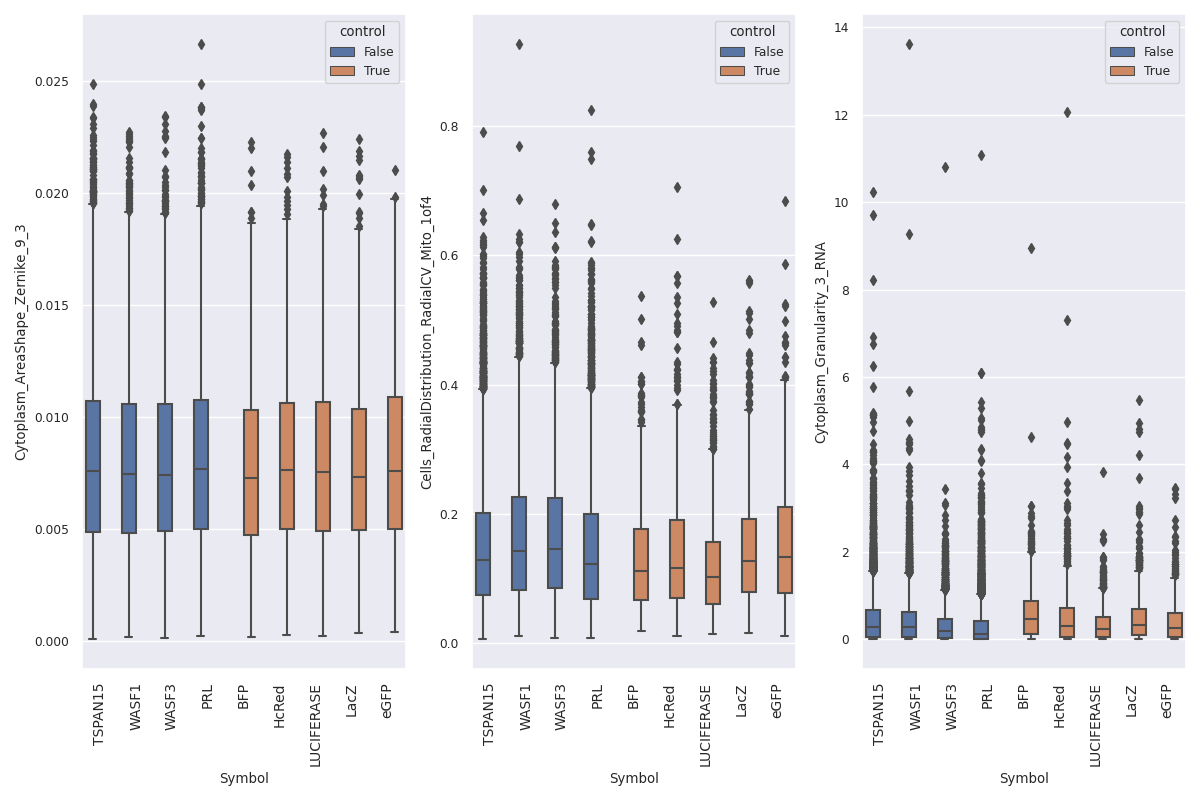

In [15]:
target_orf_ls_exist=['TSPAN15','WASF1','WASF3','PRL']
sns.set(font_scale = 0.8)
order_ls=target_orf_ls_exist+df_sc_control.Symbol.unique().tolist()
fig, ax = plt.subplots(1,3,figsize=(4*3, 8))
for f in range(len(feature_list)):
    sns.boxplot(x="Symbol", y=feature_list[f],hue="control", order=order_ls, data=full_data,ax=ax[f])
    # sns.catplot(x="Symbol", y=feature_list[0], hue="control",order=order_ls,data=full_data, kind="violin",ax=ax)
    ax[f].set_xticklabels(ax[f].get_xticklabels(),rotation=90,fontsize=10);
    plt.tight_layout()



In [ ]:
target_orf_ls_exist=['TSPAN15','WASF1','WASF3','PRL']

In [ ]:
log_scale=(False, True)

<IPython.core.display.Javascript object>


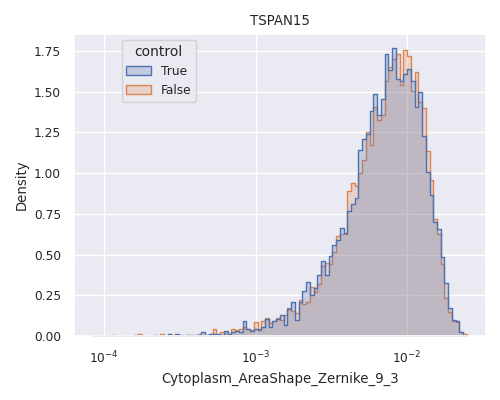

<IPython.core.display.Javascript object>


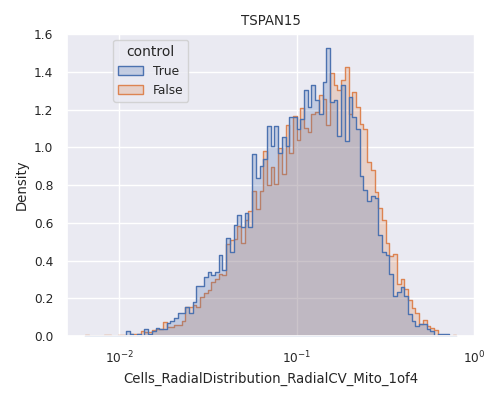

<IPython.core.display.Javascript object>


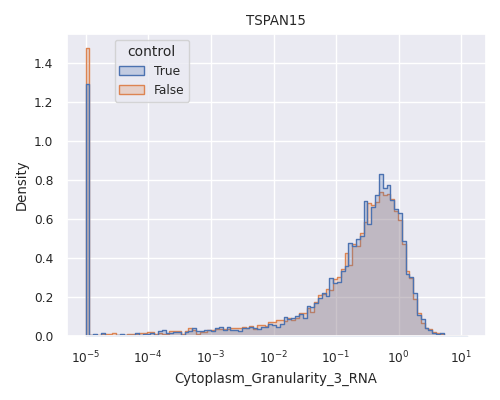

<IPython.core.display.Javascript object>


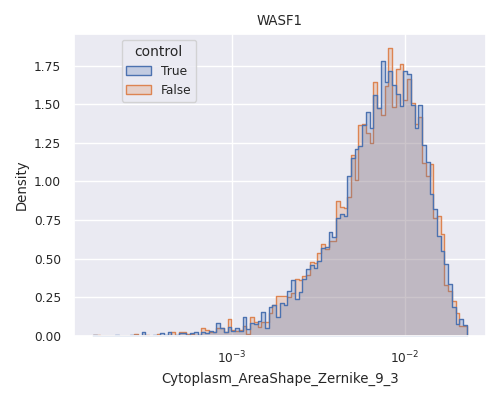

<IPython.core.display.Javascript object>


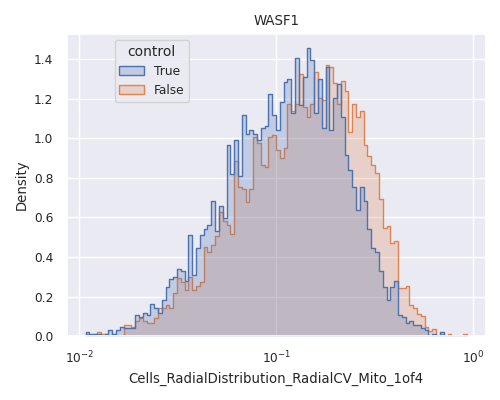

<IPython.core.display.Javascript object>


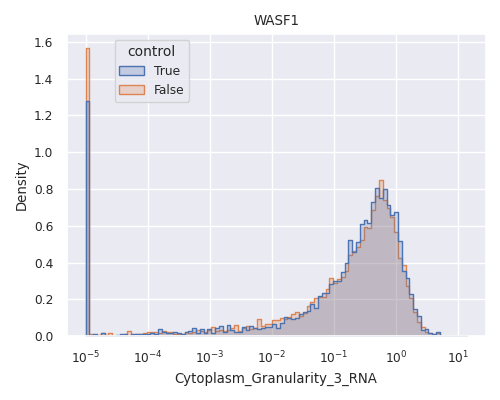

<IPython.core.display.Javascript object>


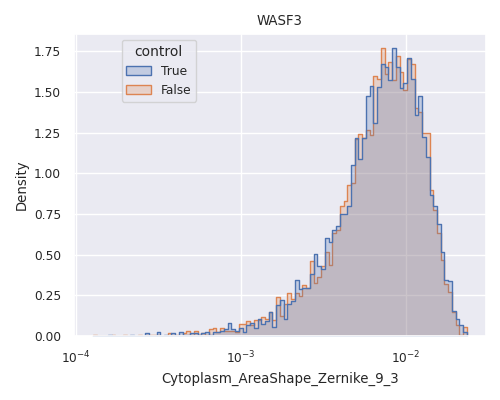

<IPython.core.display.Javascript object>


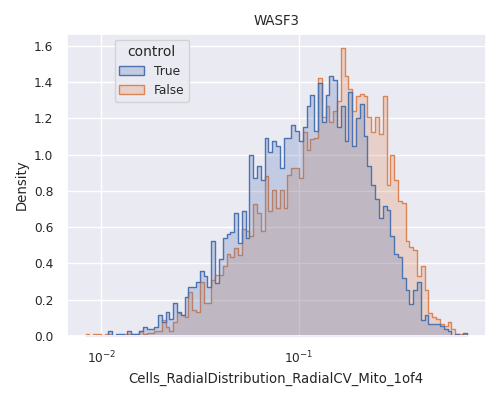

<IPython.core.display.Javascript object>


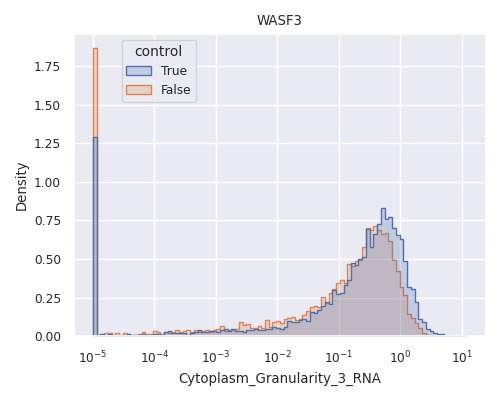

<IPython.core.display.Javascript object>


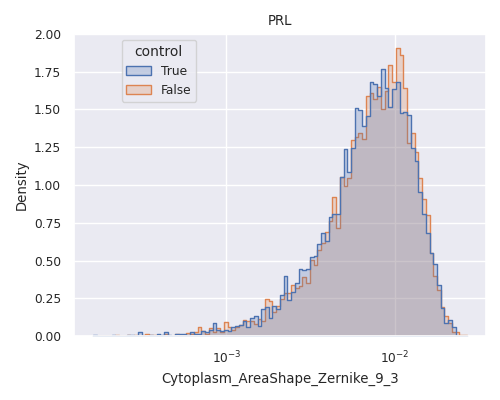

<IPython.core.display.Javascript object>


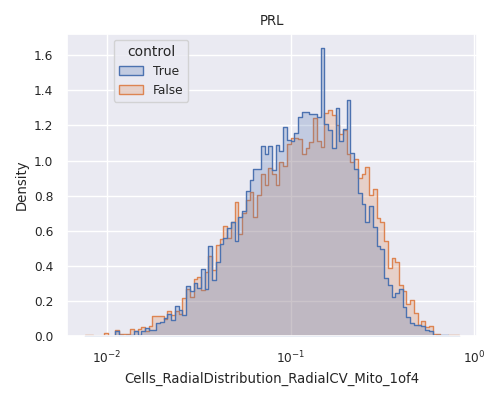

<IPython.core.display.Javascript object>


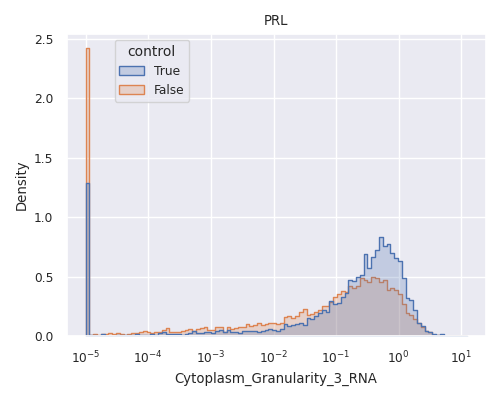

In [72]:
binss=100
log_scale_enabled=False
for t in target_orf_ls_exist:        
    for f in range(len(feature_list)):

        full_data_plot=full_data[(full_data['Symbol']==t) | (full_data['control']==True)].reset_index(drop=True)

    # full_data_plot2=full_data_plot.copy()
        full_data_plot[feature_list]=full_data_plot[feature_list]+0.00001    

        fig, axes = plt.subplots(figsize=(5,4))
        g=sns.histplot(data=full_data_plot,x=feature_list[f], bins=binss,stat="density",\
                 hue="control",hue_order=[True,False],element="step",common_norm=False,legend=True,log_scale=(True, False))   
        plt.title(t)
    #     plt.ylabel()
    #     g=sns.displot(data=full_data_plot, x=feature_list[f], hue="control", kind="hist")
        perc90=np.percentile(full_data_plot[feature_list[f]].values,99)
    #     g.set_xlim(full_data_plot[feature_list[f]].min(),perc90);
        sns.move_legend(g, "upper left", bbox_to_anchor=(.1, 1), title_fontsize=10)
        plt.tight_layout()
    #     plt.legend(loc='upper left')

    #     pl
    #     g.set(ylim=(full_data_plot[feature_list[f]].min(),perc90))
    #     sns.distplot(null_corr_ls,kde=True,hist=True,bins=100,label="random pairs",ax=axes,norm_hist=True);
    #     sns.distplot(rep_corr_ls,kde=True,hist=True,bins=100,label="replicate pairs",ax=axes,norm_hist=True,color='r');  

In [40]:
feature_list

['Cytoplasm_AreaShape_Zernike_9_3',
 'Cells_RadialDistribution_RadialCV_Mito_1of4',
 'Cytoplasm_Granularity_3_RNA']

In [26]:
full_data_plot[feature_list].dtypes

Cytoplasm_AreaShape_Zernike_9_3                float64
Cells_RadialDistribution_RadialCV_Mito_1of4    float64
Cytoplasm_Granularity_3_RNA                    float64
dtype: object

0.0

In [63]:
full_data_plot[feature_list[2]].min()

0.0